In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import datetime
pd.set_option('display.max_colwidth', 1000)
pd.options.display.max_rows = 999

In [2]:
%cd drive/My Drive/ENGIE/clean_cooking

/content/drive/My Drive/ENGIE/clean_cooking


In [3]:
!pwd

/content/drive/My Drive/ENGIE/clean_cooking


In [0]:
#df_overdue.columns

Discard Payments with no Phone Number supplied ('\N')

In [5]:
df_overdue=pd.read_excel('Overdue Payment form for analysis.xlsx')
df_payments=pd.read_excel('Phone payments for Axel.xlsx')
df_act=pd.read_excel('Customer information for Axel.xlsx')

print('The dimensions of the overdue payment df (df_overdue) are:',df_overdue.shape)
print('The dimensions of the phone payment df (df_payments) are:',df_payments.shape)
print('The dimensions of the customer activation df (df_act) are:',df_act.shape)



df_overdue=df_overdue.rename(columns={"Timestamp":"Timestamp Overdue Call","I'm calling to see how you are enjoying your Fumba unit. Do you have some time to speak now?":"Time for call","Enter the phone number that is registered as the customer's primary phone number.1":"Phone Number","Enter the amount of money on which the customer is being late:":"Amount Overdue","Enter the number of days for which the customer has been late:":"Days Overdue"})
df_overdue=df_overdue.loc[:,['Timestamp Overdue Call','Time for call','Phone Number','Amount Overdue','Days Overdue']]
df_overdue['Days Overdue']=df_overdue['Days Overdue'].astype(int)
df_payments=df_payments.loc[df_payments['Phone Number']!=r'\N',:]


FILTER_CALL=1 #if 1, select people who talked with call center for overdue payment discussion



orig_length=df_overdue.shape[0]
if FILTER_CALL==1:
  df_overdue=df_overdue.loc[df_overdue['Time for call']=='Yes',:]
  print('overdue call dataset reducted to',round(df_overdue.shape[0]/orig_length*100,2),'% of original size with',df_overdue.shape[0],'calls registered')
elif FILTER_CALL==0:
  df_overdue=df_overdue.loc[(df_overdue['Time for call']=='No') | (df_overdue['Time for call']=='Phone off'),:]
  print('overdue call dataset reducted to',round(df_overdue.shape[0]/orig_length*100,2),'% of original size with',df_overdue.shape[0],'calls registered')
else:
  print('full overdue call dataset used (with people who had no time to talk included)')


The dimensions of the overdue payment df (df_overdue) are: (1273, 71)
The dimensions of the phone payment df (df_payments) are: (8149, 8)
The dimensions of the customer activation df (df_act) are: (701, 8)
overdue call dataset reducted to 53.89 % of original size with 686 calls registered


In [6]:
df_payments.head()

,Phone Number,Amount,Date of payment,Pilot,Pricing scheme,Network reference,Narrative,TransactionID
0,256782385970,7000,2020-03-05 09:40:13,PILOT-3,GOS 3.1,36622242940,Funds Withdrawal (Auto),5e609eb8dc1c3
1,256788716239,14000,2020-03-05 09:33:11,PILOT-3,RTO 3.1,85564249,Funds Withdrawal (Auto),5e609d136beb1
2,256785588493,14000,2020-03-05 09:04:11,PILOT-3,FFS 3.2,85560864,Funds Withdrawal (Auto),5e60963941a9b
3,256779959251,3500,2020-03-05 09:03:54,PILOT-1,GOS 3.1,85560886,Funds Withdrawal (Auto),5e60963e1c551
4,256773248788,3500,2020-03-05 08:32:43,PILOT-1,GOS 3.1,36620375409,Funds Withdrawal (Auto),5e608eeb074e1


In [0]:
df_payments=df_payments.groupby('Phone Number',as_index=False).agg({'Date of payment':lambda x: list(x),'Amount':lambda x:list(x),'Pricing scheme':'last'})
df_overdue=df_overdue.groupby('Phone Number',as_index=False).agg({'Timestamp Overdue Call':lambda x:list(x),'Amount Overdue':lambda x: list(x),'Days Overdue':lambda x:list(x)})

In [0]:
df=df_overdue.merge(df_payments,left_on='Phone Number',right_on='Phone Number')

In [0]:
def monthly_commitment(pricing_scheme):
  if pricing_scheme=='GOS 3.1':
    monthly_commitment=28750
  elif pricing_scheme=='FFS 3.3':
    monthly_commitment=15000
  elif pricing_scheme=='FFS 3.2':
    monthly_commitment=22500
  elif pricing_scheme=='FFS 3.1':
    monthly_commitment=32500
  elif pricing_scheme=='RTO 3.1':
    monthly_commitment=41250
  return monthly_commitment

In [0]:
def daily_commitment(pricing_scheme):
  return monthly_commitment(pricing_scheme)/30.4368499

In [0]:
df['monthly commitment']=df['Pricing scheme'].apply(monthly_commitment)

In [12]:
df.shape

(300, 8)

In [0]:
df_act=df_act[['Primary Tel','Date registered']]
df=df.merge(df_act,left_on='Phone Number',right_on='Primary Tel')

In [0]:
df['Amount Overdue Calls']=df['Timestamp Overdue Call'].apply(len)

In [0]:
clients_more_than_1_call=df.loc[df['Amount Overdue Calls']>1,'Amount Overdue Calls'].shape[0]
clients_1_call=df.loc[df['Amount Overdue Calls']==1,'Amount Overdue Calls'].shape[0]
clients_overdue=df.shape[0]

In [0]:
def convert_date(datetimelist):
  if isinstance(datetimelist,list):
    for i in range(0,len(datetimelist)):
      datetimelist[i]=datetimelist[i].to_pydatetime()
  else:
      datetimelist=datetimelist.to_pydatetime()
  return datetimelist

In [0]:
def sort_index(datetimelist):
  s = np.array(datetimelist) 
  sort_index = np.argsort(s) #sort from earliest to later
  return sort_index 

In [0]:
def rearrange(ls,idx):
  ls=np.array(ls) 
  return ls[idx]

In [0]:
#df['Timestamp Overdue Call']=df['Timestamp Overdue Call'].apply(convert_date)
#df['Date of payment']=df['Date of payment'].apply(convert_date)
#df['Date registered']=df['Date registered'].apply(convert_date)

In [0]:
df['Index Timestamp Overdue Call']=df['Timestamp Overdue Call'].apply(sort_index)
df['Index Date of payment']=df['Date of payment'].apply(sort_index)

In [0]:
df['Timestamp Overdue Call']=df.apply(lambda x: rearrange(x['Timestamp Overdue Call'], x['Index Timestamp Overdue Call']),axis=1)
df['Amount Overdue']=df.apply(lambda x: rearrange(x['Amount Overdue'], x['Index Timestamp Overdue Call']),axis=1)
df['Days Overdue']=df.apply(lambda x: rearrange(x['Days Overdue'], x['Index Timestamp Overdue Call']),axis=1)


In [0]:
df['Date of payment']=df.apply(lambda x: rearrange(x['Date of payment'], x['Index Date of payment']),axis=1)
df['Amount']=df.apply(lambda x: rearrange(x['Amount'], x['Index Date of payment']),axis=1)


Text(0, 0.5, 'Amount of overdue clients')

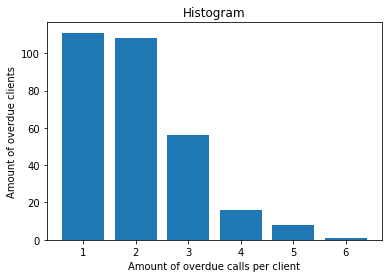

In [23]:
serie=df['Amount Overdue Calls'].value_counts()
plt.bar(serie.index,serie.values)
plt.title('Histogram')
plt.xlabel('Amount of overdue calls per client')
plt.ylabel('Amount of overdue clients')

In [24]:
print(round(df.shape[0]/df_payments.shape[0]*100,2),"% of registered clients (with possible exclusions, eg. faulty phone number, no response from overdue call) have been contacted due to overdue payment")

47.39 % of registered clients (with possible exclusions, eg. faulty phone number, no response from overdue call) have been contacted due to overdue payment


In [25]:
print(round(clients_1_call/clients_overdue*100,2),"% of overdue clients have been contacted once for an overdue payment",round(clients_more_than_1_call/clients_overdue*100,2),"% of overdue clients have been contacted more than once for an overdue payment")

37.0 % of overdue clients have been contacted once for an overdue payment 63.0 % of overdue clients have been contacted more than once for an overdue payment


In [31]:
df.shape

(300, 14)

In [0]:
def delete_calls_less_than_5days(call_date_list):
  idxs_to_del=[]
  for idx in range(1,len(call_date_list)):
    if (call_date_list[idx]-call_date_list[idx-1]).days<5:
      idxs_to_del.append(idx-1)
  call_date_list=np.delete(call_date_list,idxs_to_del)
  return call_date_list

In [28]:
print(df.loc[6,'Timestamp Overdue Call'])
delete_calls_less_than_5days(df.loc[6,'Timestamp Overdue Call'])

[Timestamp('2019-12-11 17:17:48.445000')
 Timestamp('2019-12-12 16:38:49.032000')
 Timestamp('2020-02-03 09:32:23.695000')]


array([Timestamp('2019-12-12 16:38:49.032000'),
       Timestamp('2020-02-03 09:32:23.695000')], dtype=object)

In [0]:
df['Timestamp Overdue Call filtered']=df.apply(lambda x: delete_calls_less_than_5days(x['Timestamp Overdue Call']),axis=1)

In [0]:
last_date=pd.Timestamp('2020-3-5')
def add_fake_call(call_date_list,last_date): #to split final period in 2 (last_call to last_date)
  last_call=call_date_list[-1]
  if (last_date.date()-last_call.date()).days>=40: #more than 40 days at least
    no_of_days=round(((last_date.date()-last_call.date()).days)/2)
    fake_call=last_call.date()+pd.DateOffset(days=no_of_days)
    call_date_list=np.append(call_date_list,fake_call)
  else:
    call_date_list=None
  return call_date_list

In [0]:
df['Timestamp Overdue Call filtered']=df.apply(lambda x: add_fake_call(x['Timestamp Overdue Call filtered'],last_date),axis=1)

In [33]:
df.shape

(300, 14)

In [0]:
def separate_dates_and_payments(call_date_list,payment_date_list,amount_list,last_date):
  seperated_date_list=[]
  seperated_payment_list=[]
  for call_date in call_date_list:
    short_date_list=[]
    short_payment_list=[]
    for payment_date,payment in zip(payment_date_list,amount_list):
      if (call_date.date()-payment_date.date()).days>0:
        short_date_list.append(payment_date)
        short_payment_list.append(payment)
        payment_date_list=np.delete(payment_date_list,0)
        amount_list=np.delete(amount_list,0)
      else:
        break
    seperated_date_list.append(short_date_list)
    seperated_payment_list.append(short_payment_list)
  if len(payment_date_list!=0): 
    seperated_date_list.append(payment_date_list)
    seperated_payment_list.append(amount_list)
  else:
    seperated_date_list.append([])
    seperated_payment_list.append([])
  return pd.Series([seperated_date_list,seperated_payment_list])

In [35]:
df.dropna(subset=['Timestamp Overdue Call filtered'],inplace=True)
print(df.shape)
df[['Separated timestamp payments','Separated payment amounts']]=df.apply(lambda x: separate_dates_and_payments(x['Timestamp Overdue Call filtered'],x['Date of payment'],x['Amount'],last_date),axis=1)

(239, 14)


In [0]:
def calc_days_between(call_date_list,registration_date,last_date):
  days_in_between=[None]*(len(call_date_list)+1)
  for idx in range(0,len(call_date_list)+1):
    if idx==0:
      days_in_between[0]=(call_date_list[0].date()-registration_date.date()).days
    elif idx==len(call_date_list):
      days_in_between[-1]=(last_date.date()-call_date_list[-1].date()).days
    else:
      days_in_between[idx]=(call_date_list[idx].date()-call_date_list[idx-1].date()).days
  return days_in_between

In [0]:
df['Days between calls']=df.apply(lambda x: calc_days_between(x['Timestamp Overdue Call filtered'],x['Date registered'],last_date),axis=1)

In [0]:
def calc_avg_daily_payment(separated_payment_amount_list,days_between_calls_list):
  avg_payment_list=[]
  for payments,days in zip(separated_payment_amount_list,days_between_calls_list):
    avg_payment_list.append(sum(payments)/days)
  return avg_payment_list

In [0]:
df['Average daily payments']=df.apply(lambda x: calc_avg_daily_payment(x['Separated payment amounts'],x['Days between calls']),axis=1)

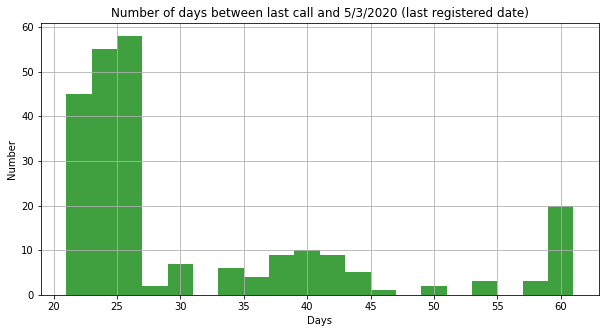

In [40]:
days_last_call_to_now=[]
for index,row in df.iterrows():
  days_last_call_to_now.append(row['Days between calls'][-1])


plt.figure(figsize=(10,5))
plt.hist(days_last_call_to_now,bins=20,facecolor='g', alpha=0.75)
plt.xlabel('Days')
plt.ylabel('Number')
plt.title('Number of days between last call and 5/3/2020 (last registered date)')
plt.grid(True)
plt.savefig('days_between_last_call_and_last_date.png')
plt.show()


In [41]:
df['Average daily payments'].apply(len).value_counts()

3    113
4    112
5      9
6      4
7      1
Name: Average daily payments, dtype: int64

In [0]:
df['Average daily payments']=df['Average daily payments'].apply(lambda x: np.asarray(x))

In [0]:
df_1call=df.loc[df['Average daily payments'].apply(len)==3,:]
df_2calls=df.loc[df['Average daily payments'].apply(len)==4,:]

In [45]:
array=df_1call['Average daily payments'].to_numpy()
np.mean(array,axis=0)

array([404.48675462, 507.79179753, 367.29663568])

In [46]:
array=df_2calls['Average daily payments'].to_numpy()
np.mean(array,axis=0)

array([411.92159033, 444.24494281, 482.99388025, 482.78582837])

In [47]:
df_1call.shape

(113, 18)

In [48]:
df_2calls.shape

(112, 18)

In [49]:
df_1call.head()

,Phone Number,Timestamp Overdue Call,Amount Overdue,Days Overdue,Date of payment,Amount,Pricing scheme,monthly commitment,Primary Tel,Date registered,Amount Overdue Calls,Index Timestamp Overdue Call,Index Date of payment,Timestamp Overdue Call filtered,Separated timestamp payments,Separated payment amounts,Days between calls,Average daily payments
4,256700390999,[2020-01-16 14:59:38.786000],[40349],[38],"[2019-10-09 08:53:01, 2019-10-12 09:31:36, 2019-10-12 09:33:52, 2019-10-16 23:03:28, 2019-11-16 00:38:49, 2019-12-17 22:30:23, 2019-12-29 09:15:32, 2020-01-20 22:25:12, 2020-01-30 22:55:46, 2020-02-28 22:39:26]","[3500, 3500, 3500, 14000, 14000, 14000, 14000, 14000, 14000, 14000]",FFS 3.1,32500,256700390999,2019-10-08 00:00:00,1,[0],"[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]","[2020-01-16 14:59:38.786000, 2020-02-09 00:00:00]","[[2019-10-09 08:53:01, 2019-10-12 09:31:36, 2019-10-12 09:33:52, 2019-10-16 23:03:28, 2019-11-16 00:38:49, 2019-12-17 22:30:23, 2019-12-29 09:15:32], [2020-01-20 22:25:12, 2020-01-30 22:55:46], [2020-02-28 22:39:26]]","[[3500, 3500, 3500, 14000, 14000, 14000, 14000], [14000, 14000], [14000]]","[100, 24, 25]","[665.0, 1166.6666666666667, 560.0]"
8,256701093772,[2020-01-21 16:04:11.812000],[43554.79],[41],"[2019-10-31 07:43:33, 2019-10-31 07:52:05, 2019-10-31 07:54:28, 2019-12-04 08:30:25, 2019-12-04 08:30:32, 2019-12-04 08:37:21, 2020-01-28 19:47:21, 2020-01-28 19:50:00, 2020-01-28 19:53:13]","[14000, 14000, 3500, 14000, 14000, 7000, 14000, 14000, 14000]",FFS 3.1,32500,256701093772,2019-10-09 00:00:00,1,[0],"[8, 7, 6, 5, 4, 3, 2, 1, 0]","[2020-01-21 16:04:11.812000, 2020-02-12 00:00:00]","[[2019-10-31 07:43:33, 2019-10-31 07:52:05, 2019-10-31 07:54:28, 2019-12-04 08:30:25, 2019-12-04 08:30:32, 2019-12-04 08:37:21], [2020-01-28 19:47:21, 2020-01-28 19:50:00, 2020-01-28 19:53:13], []]","[[14000, 14000, 3500, 14000, 14000, 7000], [14000, 14000, 14000], []]","[104, 22, 22]","[639.4230769230769, 1909.090909090909, 0.0]"
12,256701394424,[2019-12-23 16:36:00.486000],[43000],[32],"[2019-10-17 21:42:43, 2019-10-19 06:59:28, 2019-10-22 06:43:50, 2019-11-07 20:03:55, 2019-11-09 21:48:18, 2019-11-16 13:12:06, 2019-11-28 15:31:56, 2019-12-01 14:26:07, 2019-12-07 19:47:21, 2020-01-02 11:25:00, 2020-01-09 09:22:36, 2020-01-14 09:41:28, 2020-01-20 19:47:25, 2020-01-26 16:50:41]","[3500, 3500, 14000, 3500, 7000, 14000, 3500, 3500, 3500, 14000, 7000, 3500, 3500, 3500]",RTO 3.1,41250,256701394424,2019-10-11 18:20:29,1,[0],"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]","[2019-12-23 16:36:00.486000, 2020-01-28 00:00:00]","[[2019-10-17 21:42:43, 2019-10-19 06:59:28, 2019-10-22 06:43:50, 2019-11-07 20:03:55, 2019-11-09 21:48:18, 2019-11-16 13:12:06, 2019-11-28 15:31:56, 2019-12-01 14:26:07, 2019-12-07 19:47:21], [2020-01-02 11:25:00, 2020-01-09 09:22:36, 2020-01-14 09:41:28, 2020-01-20 19:47:25, 2020-01-26 16:50:41], []]","[[3500, 3500, 14000, 3500, 7000, 14000, 3500, 3500, 3500], [14000, 7000, 3500, 3500, 3500], []]","[73, 36, 37]","[767.1232876712329, 875.0, 0.0]"
16,256701496047,[2019-12-23 16:47:16.731000],[60630.1],[64],"[2019-10-28 21:27:21, 2019-11-25 21:26:54, 2019-11-25 21:33:20, 2019-12-12 19:21:56, 2019-12-27 18:39:15, 2019-12-27 18:40:10, 2019-12-27 18:41:01, 2019-12-27 18:43:56, 2019-12-27 18:52:47]","[14000, 14000, 14000, 14000, 14000, 14000, 14000, 14000, 7000]",RTO 3.1,41250,256701496047,2019-09-28 00:00:00,1,[0],"[8, 7, 6, 5, 4, 3, 2, 1, 0]","[2019-12-23 16:47:16.731000, 2020-01-28 00:00:00]","[[2019-10-28 21:27:21, 2019-11-25 21:26:54, 2019-11-25 21:33:20, 2019-12-12 19:21:56], [2019-12-27 18:39:15, 2019-12-27 18:40:10, 2019-12-27 18:41:01, 2019-12-27 18:43:56, 2019-12-27 18:52:47], []]","[[14000, 14000, 14000, 14000], [14000, 14000, 14000, 14000, 7000], []]","[86, 36, 37]","[651.1627906976744, 1750.0, 0.0]"
19,256701783444,[2020-01-17 14:52:12.672000],[52072],[52],"[2019-10-12 13:50:37, 2019-11-01 20:22:23, 2019-11-08 08:51:06, 2019-11-23 14:20:15, 2019-12-19 21:16:48, 2020-01-15 11:57:09]","[14140, 3500, 14000, 140

In [0]:
df_export_1call=pd.DataFrame()
i=0
for idx,row in df_1call.iterrows():
  df_export_1call.loc[i,'Phone Number']='+'+str(row['Phone Number'])
  df_export_1call.loc[i,'Average Daily Payment - Baseline ']=round(row['Average daily payments'][0],2)
  df_export_1call.loc[i,'Average Daily Payment - Effect Call 1 in 1st period']=round(row['Average daily payments'][1],2)
  df_export_1call.loc[i,'Average Daily Payment - Effect Call 1 in 2nd period']=round(row['Average daily payments'][2],2)
  df_export_1call.loc[i,'Days between calls']=str(row['Days between calls'])
  i+=1


In [0]:
df_export_2calls=pd.DataFrame()
i=0
for idx,row in df_2calls.iterrows():
  df_export_2calls.loc[i,'Phone Number']='+'+str(row['Phone Number'])
  df_export_2calls.loc[i,'Average Daily Payment - Baseline ']=round(row['Average daily payments'][0],2)
  df_export_2calls.loc[i,'Average Daily Payment - Effect Call 1']=round(row['Average daily payments'][1],2)
  df_export_2calls.loc[i,'Average Daily Payment - Effect Call 2 in 1st period']=round(row['Average daily payments'][2],2)
  df_export_2calls.loc[i,'Average Daily Payment - Effect Call 2 in 2nd period']=round(row['Average daily payments'][3],2)
  df_export_2calls.loc[i,'Days between calls']=str(row['Days between calls'])
  i+=1


In [61]:
df_export_2calls['Average Daily Payment - Effect Call 2 in 1st period'].mean()

482.9936607142857

In [0]:
df_export_1call.to_excel('ADP between calls (effect of call1).xlsx')

In [0]:
df_export_2calls.to_excel('ADP between calls (effect of call2).xlsx')

In [62]:
!pwd

/content/drive/My Drive/ENGIE/clean_cooking
